import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
# ^^^ pyforest auto-imports - don't write above this line
The goal of this notebook is to **explore the possibility of using Google's GTFS Data to find out how many trains are operating in the NYC Subway at any given time**.

More info about [GTFS Data](https://gtfs.org) in general. There are two types: 
- schedule data 
- real time data [extra information about this](https://doodles.patrickweaver.net/working-with-nyc-mta-realtime-subway-data/slides/4/)

I don't notice any difference between the two. I'll just use schedule data

[MTA Developer Tools](https://new.mta.info/developers). The google data for the mta should be all that we need. There's weekday, saturday, and sunday service so only need to worry about those times. Additionally, there's data on the buses, LIRR and Metro North in there, too.
- [mta metrics dashboard](https://metrics.mta.info/?subway/customerjourneytimeperformance)

[time frequency](https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_services#Train_frequency_charts) breakdown

[The project](https://tyleragreen.com/maps/new_york/) that inspired this one. [General Subway trivia](https://www.nycsubway.org/wiki/Main_Page). [Housing map that inspired the average distance visualization](https://www.nytimes.com/interactive/2023/12/30/opinion/new-york-housing-solution.html). [Ridership data Project](https://www.subwayridership.nyc/stations/611) (excludes omny data and is no longer updated). [Pandemic Recovery Dashboard](https://toddwschneider.com/dashboards/nyc-subway-turnstiles/)

Some notes about the results:
- the routes change by day of week (for example the M not running its whole route on the weekends)
- some routes include service changes (the 7 and 7 express both count as the 7)
- this also includes late nights where the routes can change dramatically (e.g.: the 5 train doesn't leave the BX at night)
- two routes don't run on the weekends: the B and W

# Imports

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings(action='once')
import folium
import matplotlib.pyplot as plt
import glob
import os
from natsort import natsorted, index_natsorted #using this to sort files numerically instead of alphabetically
import imageio
from PIL import Image

In /Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be re

# Schedule Data

In [2]:
# holdays and other days when the data would be different than expected
calendar_dates_df = pd.read_csv("data/google_transit/calendar_dates.txt") 
calendar_df = pd.read_csv("data/google_transit/calendar.txt")
routes_df = pd.read_csv("data/google_transit/routes.txt")
stop_times_df = pd.read_csv("data/google_transit/stop_times.txt")
stops_df = pd.read_csv("data/google_transit/stops.txt")
transfers_df = pd.read_csv("data/google_transit/transfers.txt")
trips_df = pd.read_csv("data/google_transit/trips.txt")
# not useful data 
# agency_df = pd.read_csv("google_transit/agency.txt")
shapes_df = pd.read_csv("data/google_transit/shapes.txt")

In [3]:
all_dfs_list = [calendar_dates_df, calendar_df, routes_df, shapes_df
               , stop_times_df, stops_df, transfers_df, trips_df]

## Frequency Data 
(that I made)

In [4]:
station_complex_full_info = pd.read_csv("saved_data/station_complex_full_info.csv", index_col=0)
# adding the rank of the station in terms of trains per hour on a 1-10 scale
station_complex_full_info['TPH_percent_rank'] = station_complex_full_info['tph'].rank(pct=True)
station_complex_full_info['Ridership_percent_rank'] = station_complex_full_info['ridership'].rank(pct=True)
station_complex_full_info['Crowdedness_percent_rank'] = station_complex_full_info['ridership_per_train'].rank(pct=True)

In [14]:
first_stop_in_trip = pd.read_csv("saved_data/first_stop_in_trip.csv", index_col=0)
route_trip_freq_by_hour = pd.read_csv("saved_data/route_trip_freq_by_hour.csv", index_col=0)
first_stop_in_trip_per_day = pd.read_csv("saved_data/first_stop_in_trip_per_day.csv", index_col=0)
daily_route_trip_freq = pd.read_csv("saved_data/daily_route_trip_freq.csv", index_col=0)
first_stop_in_trip_per_interval = pd.read_csv("saved_data/first_stop_in_trip_per_interval.csv", index_col=0)
# avg_trip_time = pd.read_csv("saved_data/avg_trip_time.csv", index_col=0)

In [6]:
daily_route_trip_freq.head(2)

,index,route_id,Saturday,Sunday,Weekday,Weekday_Adjusted,Total_trains_per_day,Trains_per_Hour_Overall,headway_minutes,route_time_seconds,route_time_minutes
0,0,1,7.750000,6.416667,9.625,48.125,62.291667,8.9,6.7,3408,56.8
1,1,2,5.791667,5.125000,6.750,33.750,44.666667,6.4,9.4,5744,95.7


# Adjustments to the GTFS Dfs

## Date Format

In [7]:
#making the times within a 24 hour range -- up to 27 
stop_times_df['arrival_time'] = [str(int(x[0:2]) - 24) + x[2:] if int(x[0:2]) >= 24 else x
                          for x in stop_times_df['arrival_time']]
stop_times_df['departure_time']  = [str(int(x[0:2]) - 24) + x[2:] if int(x[0:2]) >= 24 else x
                          for x in stop_times_df['departure_time']]
# making to a datetime
stop_times_df['arrival_time'] = pd.to_datetime(stop_times_df['arrival_time'], format="%H:%M:%S"
                                                  , errors='coerce')
stop_times_df['departure_time'] = pd.to_datetime(stop_times_df['departure_time'], format="%H:%M:%S"
                                                    , errors='coerce')

## Removing Some of the data

In [8]:
# removing lat lon data
# shapes_df.drop(columns=['shape_pt_lat', 'shape_pt_lon'], inplace=True)
stops_df.drop(columns=['stop_lat', 'stop_lon'], inplace=True)
stop_times_df = stop_times_df[~stop_times_df['arrival_time'].isnull()]

# Number of Train (sets) Running Per Day 

In [18]:
daily_route_trip_freq[['route_id', "Avg_num_trains_running"]].sort_values(by='Avg_num_trains_running'
                                                                          , ascending=False)[0:5]

,route_id,Avg_num_trains_running
12,F,10.825667
1,2,10.208000
7,A,9.830667
5,6,9.758000
20,N,9.655667


In [12]:
# 288 trains running on average! (doubling b/c I was only counting the S bound trains)
# this is trains moving at any one moment (Grand Central Shuttle counts as 1/4 of a trains)
daily_route_trip_freq['Avg_num_trains_running'].sum() * 2

288.2263333333333

In [37]:
# 3.9% have a different departure and arrival time (looks like they are the last stops)
## might be due to a switch timing thing?
21464 / stop_times_df.shape[0] 

0.038585232124398905

# Using the Frequency Data

## Adjusting the Data

In [105]:
# sorting train_time_interval by time of day
time_of_day_sorting = {'Late Night': 0, 'Rush Hour AM': 1, 'Midday': 2
                                     , 'Rush Hour PM': 3, 'Evening': 4, 'Weekend': 5}
first_stop_in_trip_per_interval = first_stop_in_trip_per_interval.sort_values(by=
                                                                              ['route_id', 'train_time_interval']
                                            , key=lambda x: x.map(time_of_day_sorting)).reset_index(drop=True)

## Previews of the Data

In [16]:
first_stop_in_trip.head(1)

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,departure_hour,route_id,shape_id,day_of_week,train_time_interval,direction
0,AFA23GEN-1038-Sunday-00_000600_1..S03R,101S,1900-01-01 00:06:00,1900-01-01 00:06:00,1,0.0,1,1..S03R,Sunday,Late Night,S


In [17]:
route_trip_freq_by_hour.head(1)

,day_of_week,departure_hour,trains_per_hour,headway_seconds,headway_minutes
route_id,,,,,
1,Saturday,0.0,3,1200.0,20.0


In [19]:
daily_route_trip_freqroute_trip_freq_overall_by_day.head(1)

,Saturday,Sunday,Weekday,Weekday_Adjusted,Total_trains_per_day,Trains_per_Hour_Overall,headway_minutes
route_id,,,,,,,
1,7.75,6.416667,9.625,48.125,62.291667,8.9,6.7


In [106]:
first_stop_in_trip_per_interval.head(2)

,route_id,train_time_interval,trains_per_hour,headway_seconds,headway_minutes
0,1,Late Night,3,1200.0,20.0
1,2,Late Night,3,1200.0,20.0


# Q & A

In [148]:
# getting the order of best performers (on weekday performance)
sorted_routes = first_stop_in_trip_per_day[first_stop_in_trip_per_day
                                 ['day_of_week']=='Weekday'].sort_values(by='trains_per_hour')['route_id'].values

## Daily Average Frequency

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

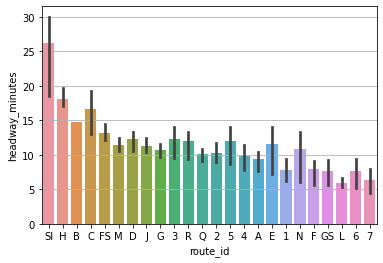

In [149]:
# with error bar 
ax = sns.barplot(data = first_stop_in_trip_per_day, x = 'route_id', y='headway_minutes', order=sorted_routes)
#     ax.title(interval)
ax.grid(axis='y')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

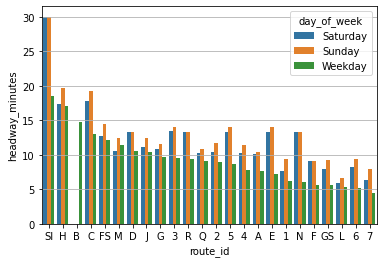

In [150]:
# separated by day 
ax = sns.barplot(data = first_stop_in_trip_per_day, x = 'route_id', y='headway_minutes'
                 , hue='day_of_week', order=sorted_routes)
#     ax.title(interval)
ax.grid(axis='y')
plt.show()

## Frequency by Interval

Late Night


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

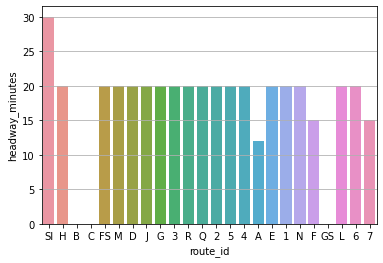

Rush Hour AM


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

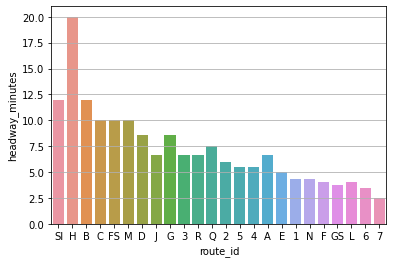

Midday


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

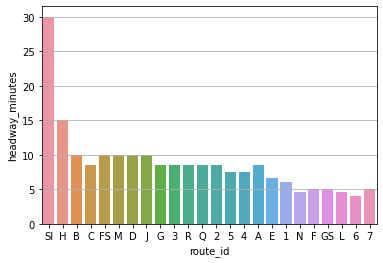

Rush Hour PM


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

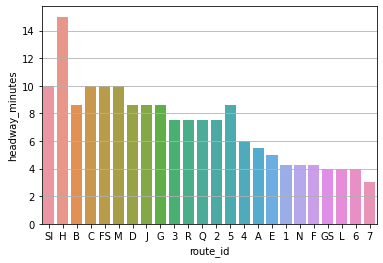

Evening


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

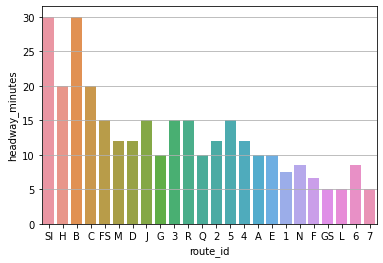

Weekend


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

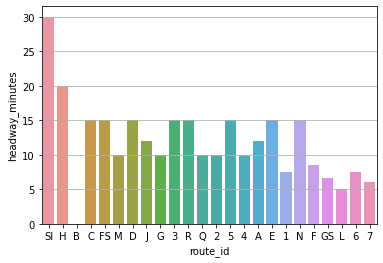

In [152]:
for interval in time_of_day_sorting.keys():
    print(interval)
    ax = sns.barplot(data = first_stop_in_trip_per_interval[first_stop_in_trip_per_interval['train_time_interval']
                                                   ==interval], x = 'route_id', y='headway_minutes', order=sorted_routes)
#     ax.title(interval)
    ax.grid(axis='y')
    plt.show()

### Best and Worst Performers by Time of Day

In [118]:
# top performers
first_stop_in_trip_per_interval.groupby(['train_time_interval', 'route_id']).sum() \
        .reset_index().sort_values(by='headway_minutes').drop_duplicates(subset='train_time_interval', keep='first')

,train_time_interval,route_id,trains_per_hour,headway_seconds,headway_minutes
78,Rush Hour AM,7,24,150.0,2.5
102,Rush Hour PM,7,20,180.0,3.0
53,Midday,6,15,240.0,4.0
6,Evening,7,12,300.0,5.0
137,Weekend,L,12,300.0,5.0
31,Late Night,A,5,720.0,12.0


In [124]:
# lowest  -- removing inf values first
# it's a tie for worst so let's just make it SIR lol 
first_stop_in_trip_per_interval[first_stop_in_trip_per_interval['headway_minutes'] < 1000].sort_values(
    by='headway_minutes').drop_duplicates(subset='train_time_interval', keep='last')

,route_id,train_time_interval,trains_per_hour,headway_seconds,headway_minutes
88,H,Rush Hour PM,4,900.0,15.0
40,H,Rush Hour AM,3,1200.0,20.0
71,SI,Midday,2,1800.0,30.0
104,B,Evening,2,1800.0,30.0
23,SI,Late Night,2,1800.0,30.0
142,SI,Weekend,2,1800.0,30.0


### Ratios between train_time_intervals for each route

In [ ]:
# maybe start with best to worst?

# Map of Stations Show Frequency

## Trains per Hour

In [72]:
# I need to use folium for the map with circles
tph_map = folium.folium.Map([40.7128, -74.0061], zoom_start=10, tiles='cartodbpositron') # city hall coords

In [73]:
for idx in range(len(station_complex_full_info)):
     folium.Circle(
            location = (station_complex_full_info.Latitude[idx], station_complex_full_info.Longitude[idx]),
            radius = station_complex_full_info['TPH_percent_rank'][idx] * 200, 
            tooltip= station_complex_full_info['Display Name'][idx], 
            popup = f"{station_complex_full_info.trip_id[idx]} TPH",
#          TPH {station_complex_full_info.ridership[idx]} Riders per day"
            color='crimson',
             fill=True,
            fill_opacity= 0.3
        ).add_to(tph_map)
tph_map.save("./saved_data/Trains_per_hour_each_station.html")

In [74]:
tph_map

## Ridership per (Week)Day

In [64]:
ridership_map = folium.folium.Map([40.7128, -74.0061], zoom_start=10, tiles='cartodbpositron') # city hall coords

In [71]:
for idx in range(len(station_complex_full_info)):
     folium.Circle(
            location = (station_complex_full_info.Latitude[idx], station_complex_full_info.Longitude[idx]),
            radius = station_complex_full_info['Ridership_percent_rank'][idx] * 200, 
            tooltip= station_complex_full_info['Display Name'][idx], 
            popup = f"{station_complex_full_info.ridership[idx]} Riders/day",
#          TPH {station_complex_full_info.ridership[idx]} Riders per day"
            color='crimson',
             fill=True,
            fill_opacity= 0.3
        ).add_to(ridership_map)
ridership_map.save("./saved_data/Ridership_at_each_station.html")

In [70]:
ridership_map

## Crowdedness

In [80]:
ridership_per_train_map = folium.folium.Map([40.7128, -74.0061], zoom_start=10, tiles='cartodbpositron') # city hall coords

In [83]:
for idx in range(len(station_complex_full_info)):
     folium.Circle(
            location = (station_complex_full_info.Latitude[idx], station_complex_full_info.Longitude[idx]),
            radius = station_complex_full_info['Crowdedness_percent_rank'][idx] * 200, 
            tooltip= station_complex_full_info['Display Name'][idx], 
            popup = f"{station_complex_full_info.ridership_per_train[idx]} Riders/train",
#          TPH {station_complex_full_info.ridership[idx]} Riders per day"
            color='crimson',
             fill=True,
            fill_opacity= 0.3
        ).add_to(ridership_per_train_map)
ridership_per_train_map.save("./saved_data/Ridership_per_train_at_each_station.html")

In [82]:
ridership_per_train_map

# Map of Train Lines Showing Frequency

In [10]:
# getting the lines to be associated with a service 
stops_df

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station
0,101,Van Cortlandt Park-242 St,40.889248,-73.898583,1.0,NaN
1,101N,Van Cortlandt Park-242 St,40.889248,-73.898583,NaN,101
2,101S,Van Cortlandt Park-242 St,40.889248,-73.898583,NaN,101
3,103,238 St,40.884667,-73.900870,1.0,NaN
4,103N,238 St,40.884667,-73.900870,NaN,103
...,...,...,...,...,...,...
1492,S30N,Tompkinsville,40.636949,-74.074835,NaN,S30
1493,S30S,Tompkinsville,40.636949,-74.074835,NaN,S30
1494,S31,St George,40.643748,-74.073643,1.0,NaN
1495,S31N,St George,40.643748,-74.073643,NaN,S31


# Saving the Transformed Data